Kaggle Competition: Carvana Image Segmentation
----------------------------------------------

In this notebook I'll train a convolutional neural network (CNN) for the [Carvana Kaggle Competition](https://www.kaggle.com/c/carvana-image-masking-challenge). The goal is to take a photo of a car, and remove the background:

![](notebook_images/objective.jpg)

The photo was taken in a special studio that rotates the car and takes 16 images from different angles:

![](notebook_images/rotations.png)

Such a set provides us with extra information as to what is the background.

Before trying to train a neural network, there is some preprocessing to do. This could be done here in this notebook, but for what I wanted to do it was easier to use ImageMagick. I'll be making a couple of preparations:

 - Reduce the resolution of the images
 - Per set of images of a car, calculate the average
 - For each image, calculate its difference with the average of its set
 - Per set of images, calculate the median
 - For each image, its difference with the median
 - Use the difference with the average to auto-crop the images

This gives us images like the following:

![](notebook_images/preprocessing.jpg)

The first objective is to reduce the size of the data, to limit the required computing resources. The resolution of the original images is 1918x1280 with three channels; far too large to train a neural network on in a reasonable amount of time without serious computing power. Unfortunately, this will mean that seriously competing on the Kaggle leaderboard is difficult; resizing the data means losing information. However, it's enough to try out the methodology in a proof of principle. So, my first step was to resize the images to 480x320.

Now how can we learn something about what is background and what is not? We see that if we take the average of the different rotations, we get a better look at the overall background of all the images. By subtracting this average from the image itself (Average diff) we remove most of the background, apart from some ghostly pieces of car from the other rotations. If we do the same thing with the median instead of the average, we get an even better result that removes most of the background.

By considering these difference images, we can already remove a large part of the background because it's completely black. This allows us to automatically crop out the interesting region of the image, so we can use a smaller neural network.

At this point we're ready to load up the features we want to use. We'll use the original image and the difference with the group median as input. The difference with the average was useful for auto-cropping, but in terms of segmenting the image probably doesn't add much when we already have the median difference.

In [4]:
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from math import floor
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D
from keras.models import Sequential, load_model
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [6]:
# List of training file basenames (i.e. without rotation
# number and extension)
filenames = open("filenames.txt").read().splitlines()

# Compile the real filenames:
# The Images
imagefiles = [
    'img_trimmed/'
    + f 
    + '_{:02d}_trimmed.png'.format(i) 
    for f in filenames for i in range(1,17)
]

# The Masks
maskfiles = [
    'mask_trimmed/rgba/'
    + f 
    + '_{:02d}_mask_trimmed.png'.format(i) 
    for f in filenames for i in range(1,17)
]

# And the median difference files
medianfiles = [
    'mdndiff_trimmed/'
    + f 
    + '_{:02d}_mdndiff.png'.format(i) 
    for f in filenames for i in range(1,17)
]

# These are the untrimmed files; only for illustration
origfiles = [
    'small/' 
    + f 
    + '_{:02d}.jpg'.format(i) 
    for f in filenames for i in range(1,17)
]

origmdnfiles = [
    'small/' 
    + f 
    + '_{:02d}_mdndiff.png'.format(i) 
    for f in filenames for i in range(1,17)
]

# Load the training data (only 2500 images; full set didn't
# fit in memory. Should upgrade to a batch generator or some
# such.)
imgdata = np.array([
    np.array(Image.open(fname)) 
    for fname in imagefiles[:2500]
])
maskdata = np.array([
    np.array(Image.open(fname)) 
    for fname in maskfiles[:2500]
])
mediandata = np.array([
    np.array(Image.open(fname)) 
    for fname in medianfiles[:2500]
])

# Just grab a couple of the original images
origdata = np.array([
    np.array(Image.open(fname)) 
    for fname in origfiles[:25]
])
origmdndata = np.array([
    np.array(Image.open(fname)) 
    for fname in origmdnfiles[:25]
])

In [2]:
# Helper functions

# I preprocessed the images, and a large part
# of them is transparent; this cuts out the
# remaining part of interest
# Function expects (M x N x 4) shape including
# alpha channel
def cut_relevant(rgba_img):
    nonempty_cols = np.where(rgba_img[:,:,3].max(axis=0)>0)[0]
    nonempty_rows = np.where(rgba_img[:,:,3].max(axis=1)>0)[0]
    cropbox = (
        min(nonempty_rows), 
        max(nonempty_rows), 
        min(nonempty_cols), 
        max(nonempty_cols)
    )
    new_img = rgba_img[
        cropbox[0]:cropbox[1]+1, 
        cropbox[2]:cropbox[3]+1,
        :]
    return new_img

# Like the function above, but returns the
# cropbox instead of the image
def get_relevant_box(rgba_img):
    nonempty_cols = np.where(
        rgba_img[:,:,3].max(axis=0)>0
    )[0]
    nonempty_rows = np.where(
        rgba_img[:,:,3].max(axis=1)>0
    )[0]
    cropbox = (
        min(nonempty_rows), 
        max(nonempty_rows), 
        min(nonempty_cols), 
        max(nonempty_cols)
    )
    return cropbox

# Resizes images to 100x100x3 for the CNN
def fix_size(rgba_img):
    rgb_img = np.array(
        Image.fromarray(
            cut_relevant(
                rgba_img
            )
        ).resize((100,100)).convert('RGB')
    )
    return rgb_img


# Convert RGB image to binary image
def to_mask(img):
    arr = np.array(img)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i,j,0] + arr[i,j,1] + arr[i,j,2] > 0:
                arr[i,j] = [1,1,1]
    return np.array(
        Image.fromarray(
            (255*arr).astype('uint8')
        ).convert('1')
        , dtype='uint8'
    )

# Takes an output image (mask) and resizes it
# back to its original shape, provided you tell
# it the original cropbox used, then sticks it
# back in a 480x320 image.
def to_large_mask(img, cropbox):
    arr = np.array(Image.fromarray(img).resize((
        cropbox[3]-cropbox[2], 
        cropbox[1]-cropbox[0]
    )))
    new_img = np.zeros((320,480))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            new_img[cropbox[0]+i, cropbox[2]+j] = arr[i, j]
    return new_img

# Convert image to pure binary array
def binarize(img):
    return (np.array(
        Image.fromarray(img)
        .convert('1')
        .getdata()).reshape(
            img.shape[1], 
            img.shape[0]
        )/255).astype('uint8')

# Apply mask to image
def apply_mask(img, mask, bg = [0,0,0]):
    masked_img = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if mask[i,j]:
                masked_img[i,j] = img[i,j]
            else:
                masked_img[i,j] = bg
    return masked_img

# Dice coefficient metric function for keras,
# borrowed from: https://github.com/jocicmarko/
# ultrasound-nerve-segmentation/blob/master/train.py

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )

## A look at the data

The plots below display the first couple of images and their target masks. It seems like our auto-cropping procedure has already selected the regions of interest fairly well.

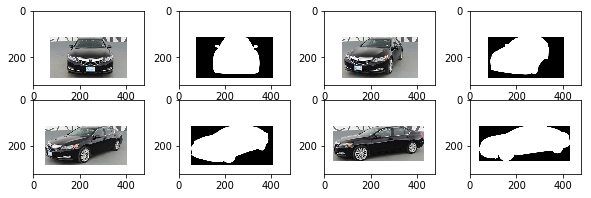

In [4]:
# A quick look at our data: source images
# and their target masks

fig, ax = plt.subplots(2,4, figsize=(10,3))
ax = ax.ravel()

for i in range(8):
    if i % 2 == 0:
        ax[i].imshow(imgdata[floor(i/2)])
    else:
        ax[i].imshow(maskdata[floor(i/2)])


plt.show()

We now want to transform the data into a size usable as input for our neural network. The cropped regions are not all the same size, so we need to standardize them. We prepare the images by selecting only the automatically cropped sections, and then resizing them to 100x100.

In [7]:
# Convert the data to the right input/output formats
imgdata_shaped = np.array([
    fix_size(img) 
    for img in imgdata
])/255

mdndata_shaped = np.array([
    fix_size(img) 
    for img in mediandata
])/255

maskdata_shaped = np.array([
    fix_size(img) 
    for img in maskdata
])

maskdata_binary = np.array([
    np.expand_dims(binarize(img), axis=2) 
    for img in maskdata_shaped
])

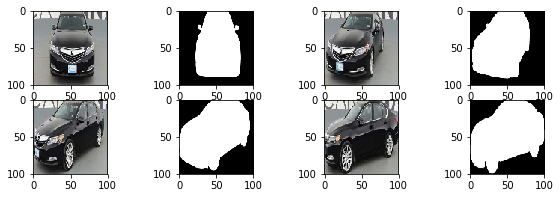

In [6]:
# Our data is now cut and resized to work as input
# and output for our neural network

fig, ax = plt.subplots(2,4, figsize=(10,3))
ax = ax.ravel()

for i in range(8):
    if i % 2 == 0:
        ax[i].imshow(imgdata_shaped[floor(i/2)])
    else:
        ax[i].imshow(maskdata_shaped[floor(i/2)])


plt.show()

This is quite a serious reduction in resolution, but my computer wasn't able to handle much more. We had better get an idea of how much this limitation on the resolution is going to cost us.

The competition is scored using the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient), a measure of similarity between two sets. It counts the number of overlapping elements between two sets (in this case, the sets of pixels labeled as 'car' rather than 'background' in predicted and true masks) relative to the mean size of the two sets.

When we scale down the resolution of our masks to 100x100, and then scale them back up to 1918x1280, we are bound not to get the exact same mask back, even though we're using a perfect mask. This will reduce the quality of our predictions independent of how good those predictions are, simply due to the scaling. Let's see how much we should expect to lose.

In [21]:
# Calculate the Dice coefficient for two arrays
def dice(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_true_f * y_pred_f).sum()
    return 2. * intersection / (y_true_f.sum() + y_pred_f.sum())

# Load up a full-size, 1918x1280 pixel mask
fullsize_mask = np.array(
    Image.open(
        'notebook_images/00087a6bd4dc_04_mask.gif'
    )
)

# Take the corresponding mask scaled down to
# 100x100, paste it back into its original 
# 480x320 image and scale that up to full
# size
rescaled_mask = (
    np.array(
        Image.fromarray(
            255*to_large_mask(
                binarize(
                    maskdata_shaped[3]
                ).astype('uint8'), 
                get_relevant_box(
                    imgdata[3]
                )
            ).astype('uint8')
        ).resize((1918, 1280)))/255
).astype('uint8')

# Calculate the Dice coefficient between the two
dice(fullsize_mask, rescaled_mask)

0.98749339126083813

Above, I loaded up an original full-size mask, and scaled the corresponding 100x100 mask back up to full size. The Dice coefficient between then two is 0.987, so I'm already losing out on model efficiency simply due to this resizing. If I were using the full-size images as input, I would not have this loss.

A reduction to 0.987 might not sound so bad, but it already ensures it's impossible to seriously compete in the Kaggle competition; the leaderboard at time of writing already has scores of over 0.99. However, let's continue with our proof of principle anyway.

The final part of the preprocessing is to scale down the median difference images in the same way, so that we can stack them with the photos.

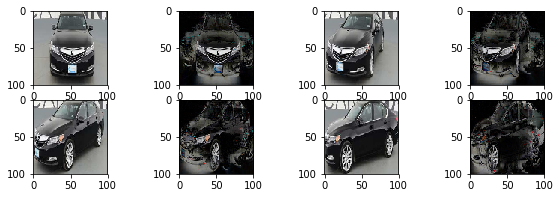

In [7]:
# We reshaped the median difference data in
# the same way.

fig, ax = plt.subplots(2,4, figsize=(10,3))
ax = ax.ravel()

for i in range(8):
    if i % 2 == 0:
        ax[i].imshow(imgdata_shaped[floor(i/2)])
    else:
        ax[i].imshow(mdndata_shaped[floor(i/2)])


plt.show()

## Training a model

Now let's see if a CNN can use the information we've provided to understand what is background and what is a car. We'll set up our input data as arrays of shape 100x100x6, i.e. 100x100 pixels, with 6 channels: the 3 RGB channels of the original image, and those of the median difference image. The code below prepares the input and targets, builds the CNN model and trains it, but this takes a while, so in the subsequence code we'll load up a pregenerated model.

In [24]:
# Set up the input features
X = np.concatenate((imgdata_shaped, mdndata_shaped), axis=3)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, maskdata_binary, test_size=0.2, random_state=42)

# Normalize input
X_mean = X_train.mean(axis=(0,1,2), keepdims=True)
X_std = X_train.std(axis=(0,1,2), keepdims=True)

X_train -= X_mean
X_train /= X_std

X_val -= X_mean
X_val /= X_std

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

In [10]:
# Set up convolutional neural network

model = Sequential()
model.add( Conv2D(16, 10, activation='relu', padding='same', input_shape=(100, 100, 6) ) )
model.add( Conv2D(32, 5, activation='relu', padding='same') )
model.add( Conv2D(1, 5, activation='sigmoid', padding='same') )

In [11]:
# Build the model
model.compile(Adam(lr=1e-3), binary_crossentropy, metrics=[dice_coef])

# Train the model
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val), batch_size=32, verbose=2)

# Save the model
model.save('model.h5')

Train on 2000 samples, validate on 500 samples
Epoch 1/40
137s - loss: 0.4243 - dice_coef: 0.7729 - val_loss: 0.3074 - val_dice_coef: 0.8407
Epoch 2/40
137s - loss: 0.2801 - dice_coef: 0.8561 - val_loss: 0.2561 - val_dice_coef: 0.8744
Epoch 3/40
122s - loss: 0.2381 - dice_coef: 0.8790 - val_loss: 0.2161 - val_dice_coef: 0.8878
Epoch 4/40
116s - loss: 0.2211 - dice_coef: 0.8891 - val_loss: 0.2251 - val_dice_coef: 0.8936
Epoch 5/40
115s - loss: 0.2099 - dice_coef: 0.8948 - val_loss: 0.2002 - val_dice_coef: 0.9033
Epoch 6/40
115s - loss: 0.1952 - dice_coef: 0.9023 - val_loss: 0.1855 - val_dice_coef: 0.9088
Epoch 7/40
113s - loss: 0.1888 - dice_coef: 0.9064 - val_loss: 0.1829 - val_dice_coef: 0.9050
Epoch 8/40
112s - loss: 0.1774 - dice_coef: 0.9121 - val_loss: 0.1757 - val_dice_coef: 0.9184
Epoch 9/40
111s - loss: 0.1694 - dice_coef: 0.9161 - val_loss: 0.1593 - val_dice_coef: 0.9222
Epoch 10/40
111s - loss: 0.1617 - dice_coef: 0.9204 - val_loss: 0.1711 - val_dice_coef: 0.9187
Epoch 11/40


## Applying the model

The model we just trained reached a dice coefficient of about 0.95 in the final epochs. Applied to the test data, the model scored 0.972 on the leaderboard; a little higher, perhaps just by sheer luck. Either score, however, is probably not good enough for a real-world production model, but it shows that such a model seems to be capable of performing this task. With more computational resources we could probably do a lot better.

What does this dice score mean in practice? Let's have a look. The plot below shows that we do approximate the shape of the car pretty well, but our model has problems with sharp corners in the shape, such as at the side mirrors.

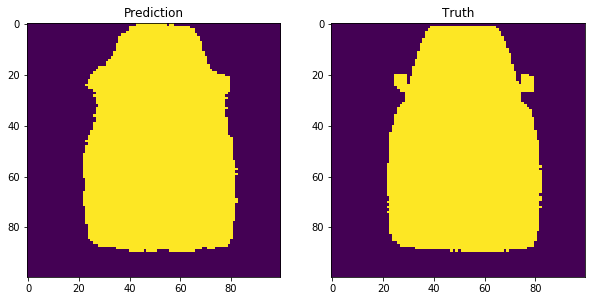

In [25]:
model = load_model('model.h5', custom_objects={'dice_coef': dice_coef})

pred0 = (model.predict(((X[0]-X_mean)/X_std)) > 0.5)
true0 = maskdata_binary[0]

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax = ax.ravel()

ax[0].set_title('Prediction')
ax[0].imshow(binary_fill_holes(pred0.reshape((100,100))))
ax[1].set_title('Truth')
ax[1].imshow(true0.reshape((100,100)))

plt.show()

Of course, we are now still dealing with 100x100 pixel output. We need to map this back to our original images. We need to resize the masks to the original auto-cropped region, and place them in the right location.

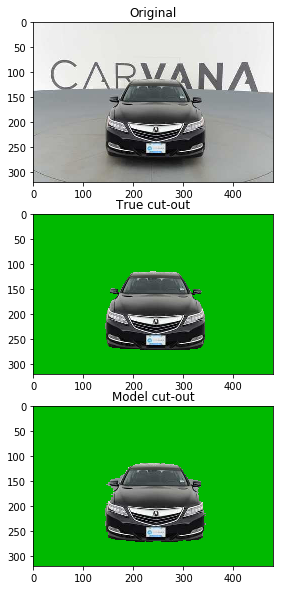

In [26]:
# Resize the prediction back to the original image size.
# We also apply an algorithm to fill any holes in the
# mask we predict, because in some cases the model 
# predicts car shapes with holes.
large_pred0 = binary_fill_holes(
    to_large_mask(
        pred0.reshape((100,100)).astype('uint8'), 
        get_relevant_box(imgdata[0])
    )
)

fig, ax = plt.subplots(3,1, figsize=(10,10))
ax = ax.ravel()

ax[0].set_title('Original')
ax[0].imshow(origdata[0])
ax[1].set_title('True cut-out')
ax[1].imshow(apply_mask(imgdata[0,:,:,:3], (maskdata[0].mean(axis=2)>=255), bg = [0,185,0]).astype('uint8'))
ax[2].set_title('Model cut-out')
ax[2].imshow(apply_mask(imgdata[0,:,:,:3], large_pred0, bg = [0,185,0]).astype('uint8'))

plt.show()

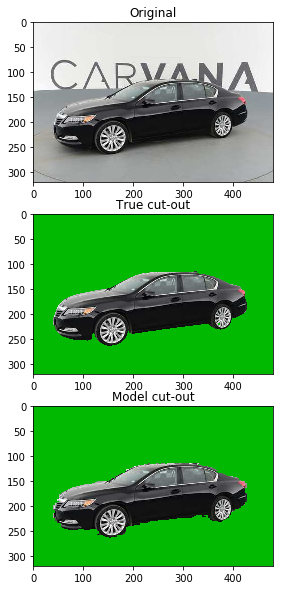

In [14]:
# Comparison for a picture viewing the car from the
# side instead of the front.
pred3 = (model.predict(((X[3]-X_mean)/X_std)) > 0.5)
large_pred3 = binary_fill_holes(
    to_large_mask(
        pred3.reshape((100,100)).astype('uint8'), 
        get_relevant_box(imgdata[3])
    )
)

fig, ax = plt.subplots(3,1, figsize=(10,10))
ax = ax.ravel()

ax[0].set_title('Original')
ax[0].imshow(origdata[3])
ax[1].set_title('True cut-out')
ax[1].imshow(apply_mask(imgdata[3,:,:,:3], (maskdata[3].mean(axis=2)>=255), bg = [0,185,0]).astype('uint8'))
ax[2].set_title('Model cut-out')
ax[2].imshow(apply_mask(imgdata[3,:,:,:3], large_pred3, bg = [0,185,0]).astype('uint8'))

plt.show()

In the second set of plots, with the car viewed from the side, we do a little better because there are no sharp corners to the shape. However, the edges of the predicted shape are very jagged, because our CNN is only 100x100 in size.

The results are not perfect, and especially for a real-world application, not really good enough, but we are on our way. We see that using the differene with the median, we indeed provide the neural network with much of the information it needs, and with the computational resources to train a larger model, we could probably get quite far with this approach.